In [1]:
import yfinance as yf
import pandas_datareader as pdr
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import itertools
import warnings
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error
from prophet import Prophet
import cufflinks as cf
import chart_studio.plotly as py
cf.go_offline()

## Data Collection and Data Manipulation

In [2]:
def get_finance_data(stock):
    s = yf.Ticker(stock)
    
    df = s.history(start = '2009-01-31', end='2021-10-22', interval = "1d")
    df = df.drop(['Dividends', 'Stock Splits'], axis=1)

    return df

In [3]:
amzn = get_finance_data('amzn')

In [4]:
amzn

,Open,High,Low,Close,Volume
Date,,,,,
2009-02-02,58.570000,62.000000,58.130001,61.150002,19324300
2009-02-03,60.869999,64.199997,60.000000,63.590000,14694600
2009-02-04,63.380001,63.439999,60.830002,61.060001,13726300
2009-02-05,61.150002,63.810001,60.630001,63.180000,10169600
2009-02-06,63.180000,67.000000,63.180000,66.550003,12044900
...,...,...,...,...,...
2021-10-15,3311.419922,3410.419922,3304.000000,3409.020020,5175100
2021-10-18,3388.360107,3449.169922,3385.100098,3446.739990,3174100
2021-10-19,3434.290039,3454.689941,3422.000000,3444.149902,2386100


In [5]:
amzn_close = amzn[['Close']]

## Data Visualization

In [6]:
amzn_close.iplot(title='Stock Close Prices', fill = True, xTitle='Dates',yTitle='Close Prices', theme='space')

In [7]:
amzn['Volume'].iplot(title='Volume', xTitle='Dates', yTitle='Volume', theme='space')

## Modeling

In [8]:
amzn_close

,Close
Date,
2009-02-02,61.150002
2009-02-03,63.590000
2009-02-04,61.060001
2009-02-05,63.180000
2009-02-06,66.550003
...,...
2021-10-15,3409.020020
2021-10-18,3446.739990
2021-10-19,3444.149902


## ADF Test

Check for stationary series using the Augmented Dickey Fuller Test.
The ADF test indicates whether or not differencing has to be done or not

In [9]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(amzn_close.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 2.145600
p-value: 0.998835


## Differencing Term (d)

Since P-value is greater than the significance level, let’s difference the series and see how the autocorrelation plot looks like.

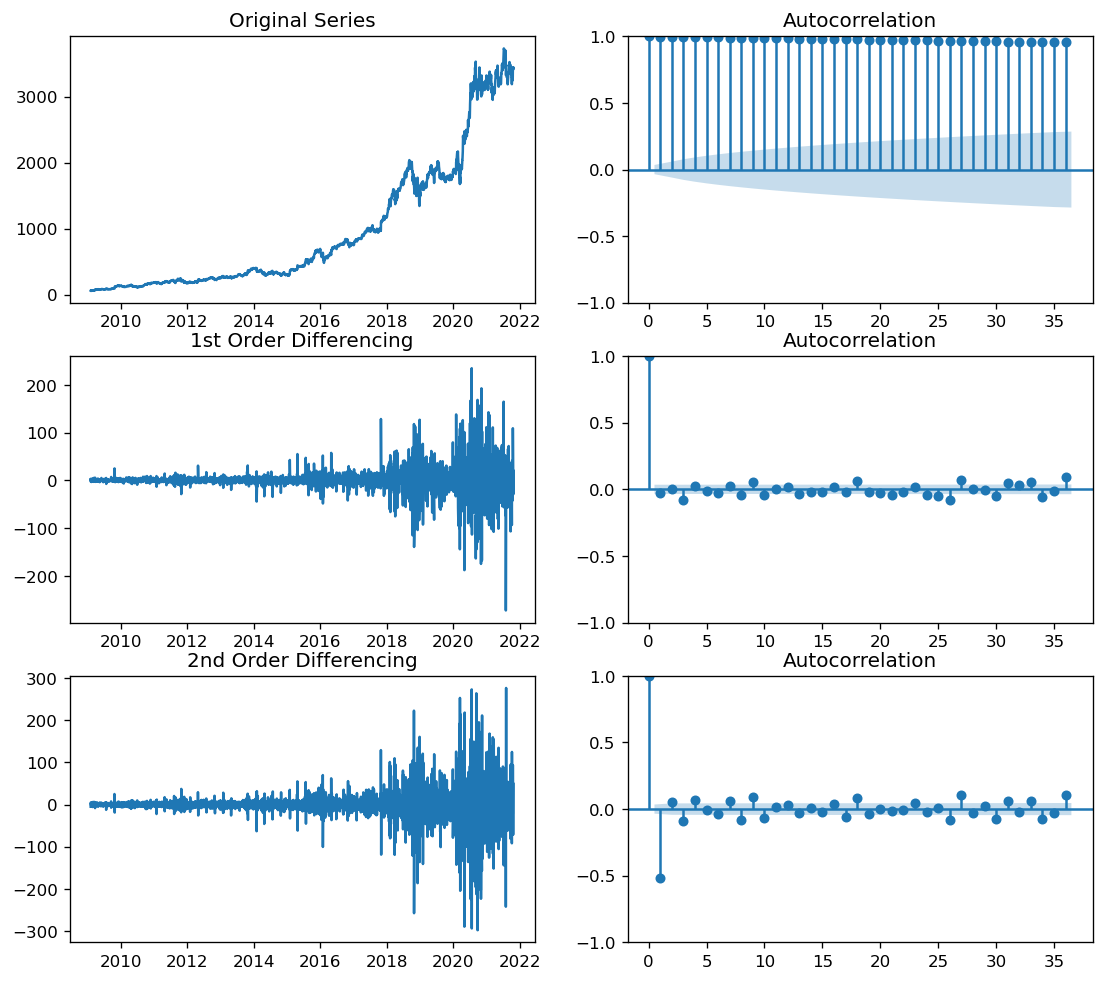

In [10]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(11,10), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(amzn_close); axes[0, 0].set_title('Original Series')
plot_acf(amzn_close, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(amzn_close.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(amzn_close.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(amzn_close.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(amzn_close.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

For the above series, the time series reaches stationarity with 1 order of differencing.

## AR term (p)

C:\Users\ronak\Anaconda3\envs\capstone\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



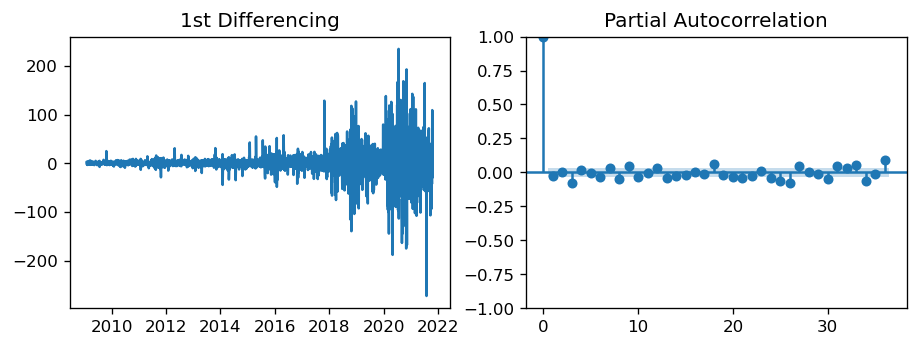

In [11]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(amzn_close.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(amzn_close.diff().dropna(), ax=axes[1])

plt.show()

ACF lag 1 is quite significant since is well above the significance line, that is why the lag term will be closer to 1

## MA Term (q)

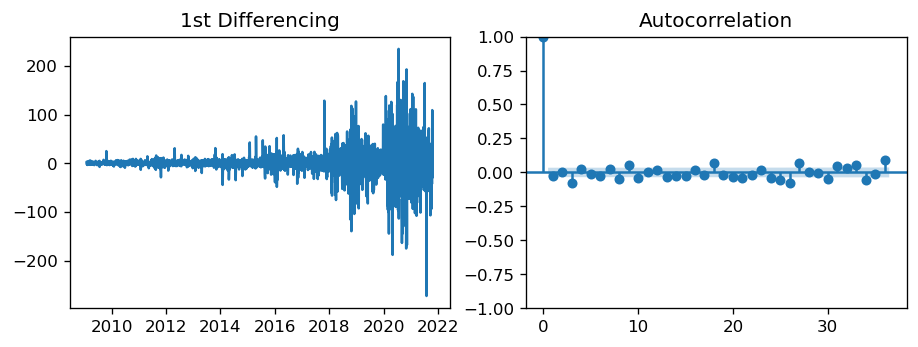

In [12]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})


fig, axes = plt.subplots(1, 2)
axes[0].plot(amzn_close.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(amzn_close.diff().dropna(), ax=axes[1])

plt.show()

The 1st lag is well above the signifigance line so the q term will be set to 1

# ARIMA

## Train-Test Split

In [13]:
n = int(len(amzn_close) * 0.80)
train = amzn_close[:n]
test = amzn_close[n:]

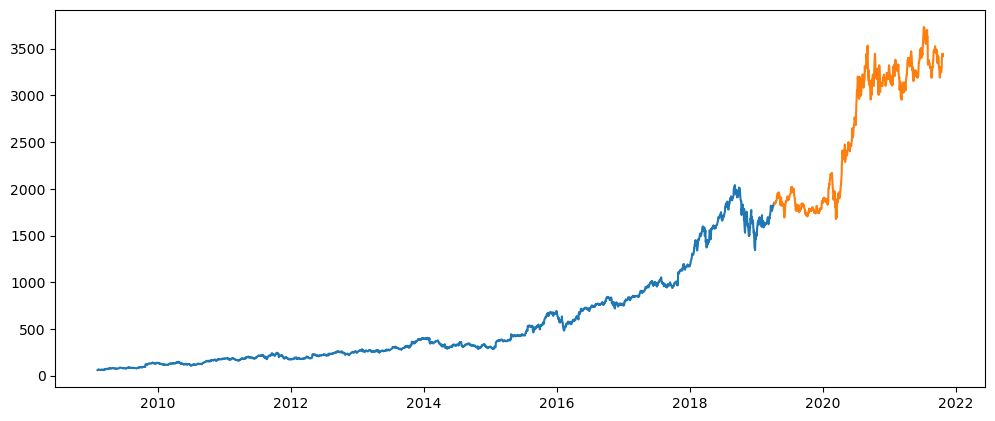

In [14]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')

## Prediction

In [15]:
model = SARIMAX(amzn_close, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

C:\Users\ronak\Anaconda3\envs\capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\ronak\Anaconda3\envs\capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\ronak\Anaconda3\envs\capstone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\ronak\Anaconda3\envs\capstone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3204
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -14966.355
Date:                Thu, 28 Oct 2021   AIC                          29938.711
Time:                        08:28:13   BIC                          29956.926
Sample:                             0   HQIC                         29945.241
                               - 3204                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0113      0.354     -0.032      0.975      -0.706       0.683
ma.L1         -0.0111      0.355     -0.031      0.975      -0.707       0.684
sigma2       670.3902      5.437    123.299      0.0

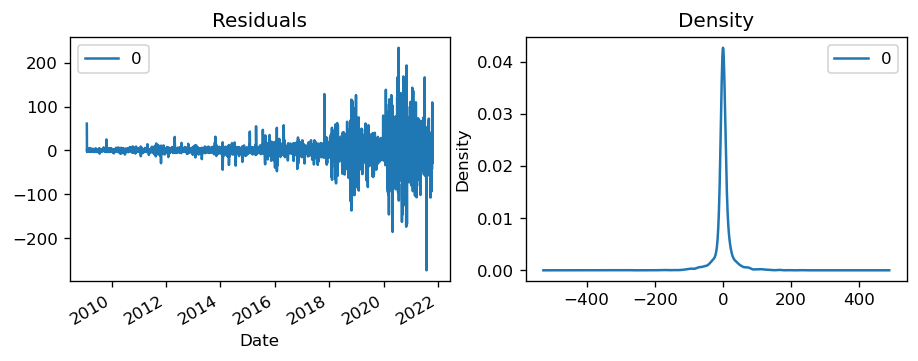

In [16]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [17]:
pred = model_fit.predict(start=pd.to_datetime('2019-04-08'), dynamic=False)
plt.show()

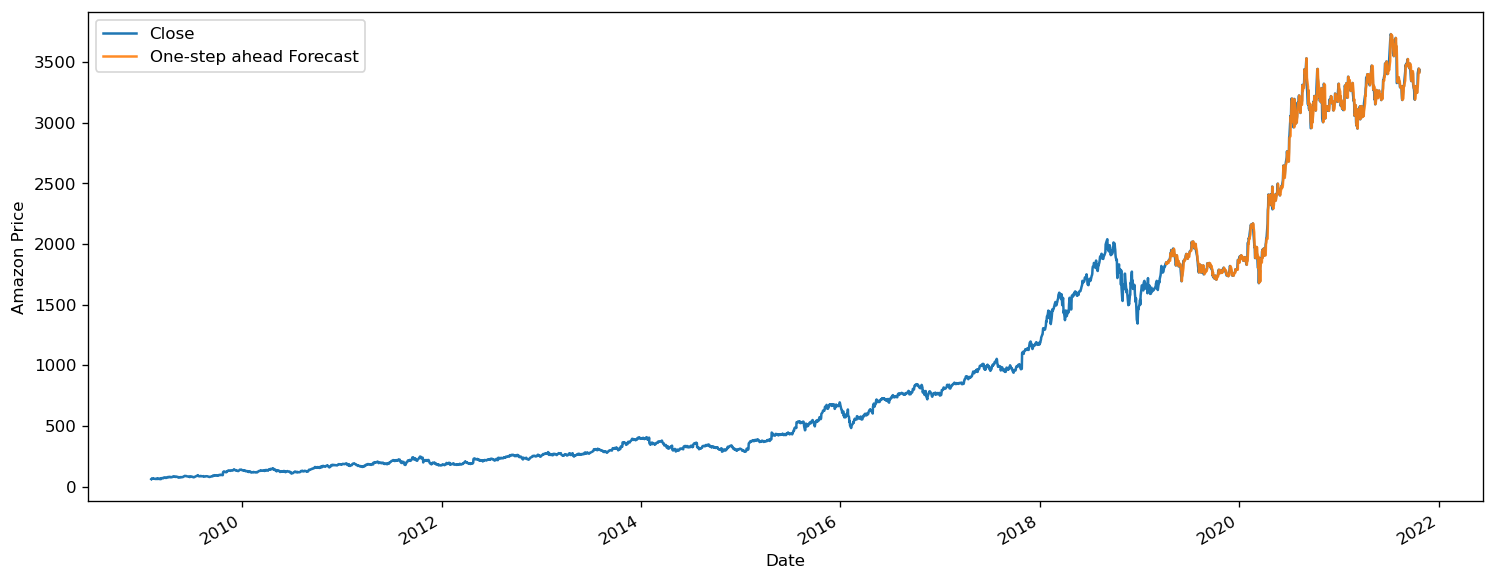

In [43]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = amzn_close.plot(label='observed')

# Plot predicted values
pred.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Amazon Price')
plt.legend()

plt.show();

In [19]:
value_forecasted = pred
value_truth = amzn_close['Close']['2019-04-08':]

# Compute the root mean square error
mse = ((value_forecasted - value_truth) ** 2).mean()
print('The Root Mean Squared Error of prediction is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of prediction is 50.1


# PMDARIMA 

In [20]:
import pmdarima as pm
from pmdarima.arima import ndiffs
from pmdarima.metrics import smape

In [22]:
kpss_diffs = ndiffs(train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")

Estimated differencing term: 2


In [23]:
auto = pm.auto_arima(train, d=n_diffs, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.92 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=22780.379, Time=0.16 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=22067.354, Time=0.40 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.87 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=22778.379, Time=0.11 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=21755.355, Time=0.48 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=21581.859, Time=0.56 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=21402.778, Time=1.36 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=21335.346, Time=2.37 sec
 ARIMA(6,2,0)(0,0,0)[0] intercept   : AIC=21301.120, Time=2.40 sec
 ARIMA(6,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=8.86 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=7.92 sec
 ARIMA(6,2,0)(0,0,0)[0]             : AIC=21299.123, Time=1.14 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=21333.348, Time=1.11 sec
 ARIMA(6,2,1)(0,0,0)[0]             : AIC=i

In [24]:
print(auto.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2563
Model:               SARIMAX(6, 2, 0)   Log Likelihood              -10642.561
Date:                Thu, 28 Oct 2021   AIC                          21299.123
Time:                        08:42:16   BIC                          21340.060
Sample:                             0   HQIC                         21313.967
                               - 2563                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8781      0.008   -111.921      0.000      -0.894      -0.863
ar.L2         -0.7641      0.011    -70.603      0.000      -0.785      -0.743
ar.L3         -0.6243      0.014    -45.547      0.0

In [25]:
model = auto  # seeded from the model we've already fit

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in test['Close']:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

print(f"Mean squared error: {mean_squared_error(test['Close'], forecasts)}")
print(f"SMAPE: {smape(test['Close'], forecasts)}")

Mean squared error: 2914.7429774631737
SMAPE: 1.43911959872658


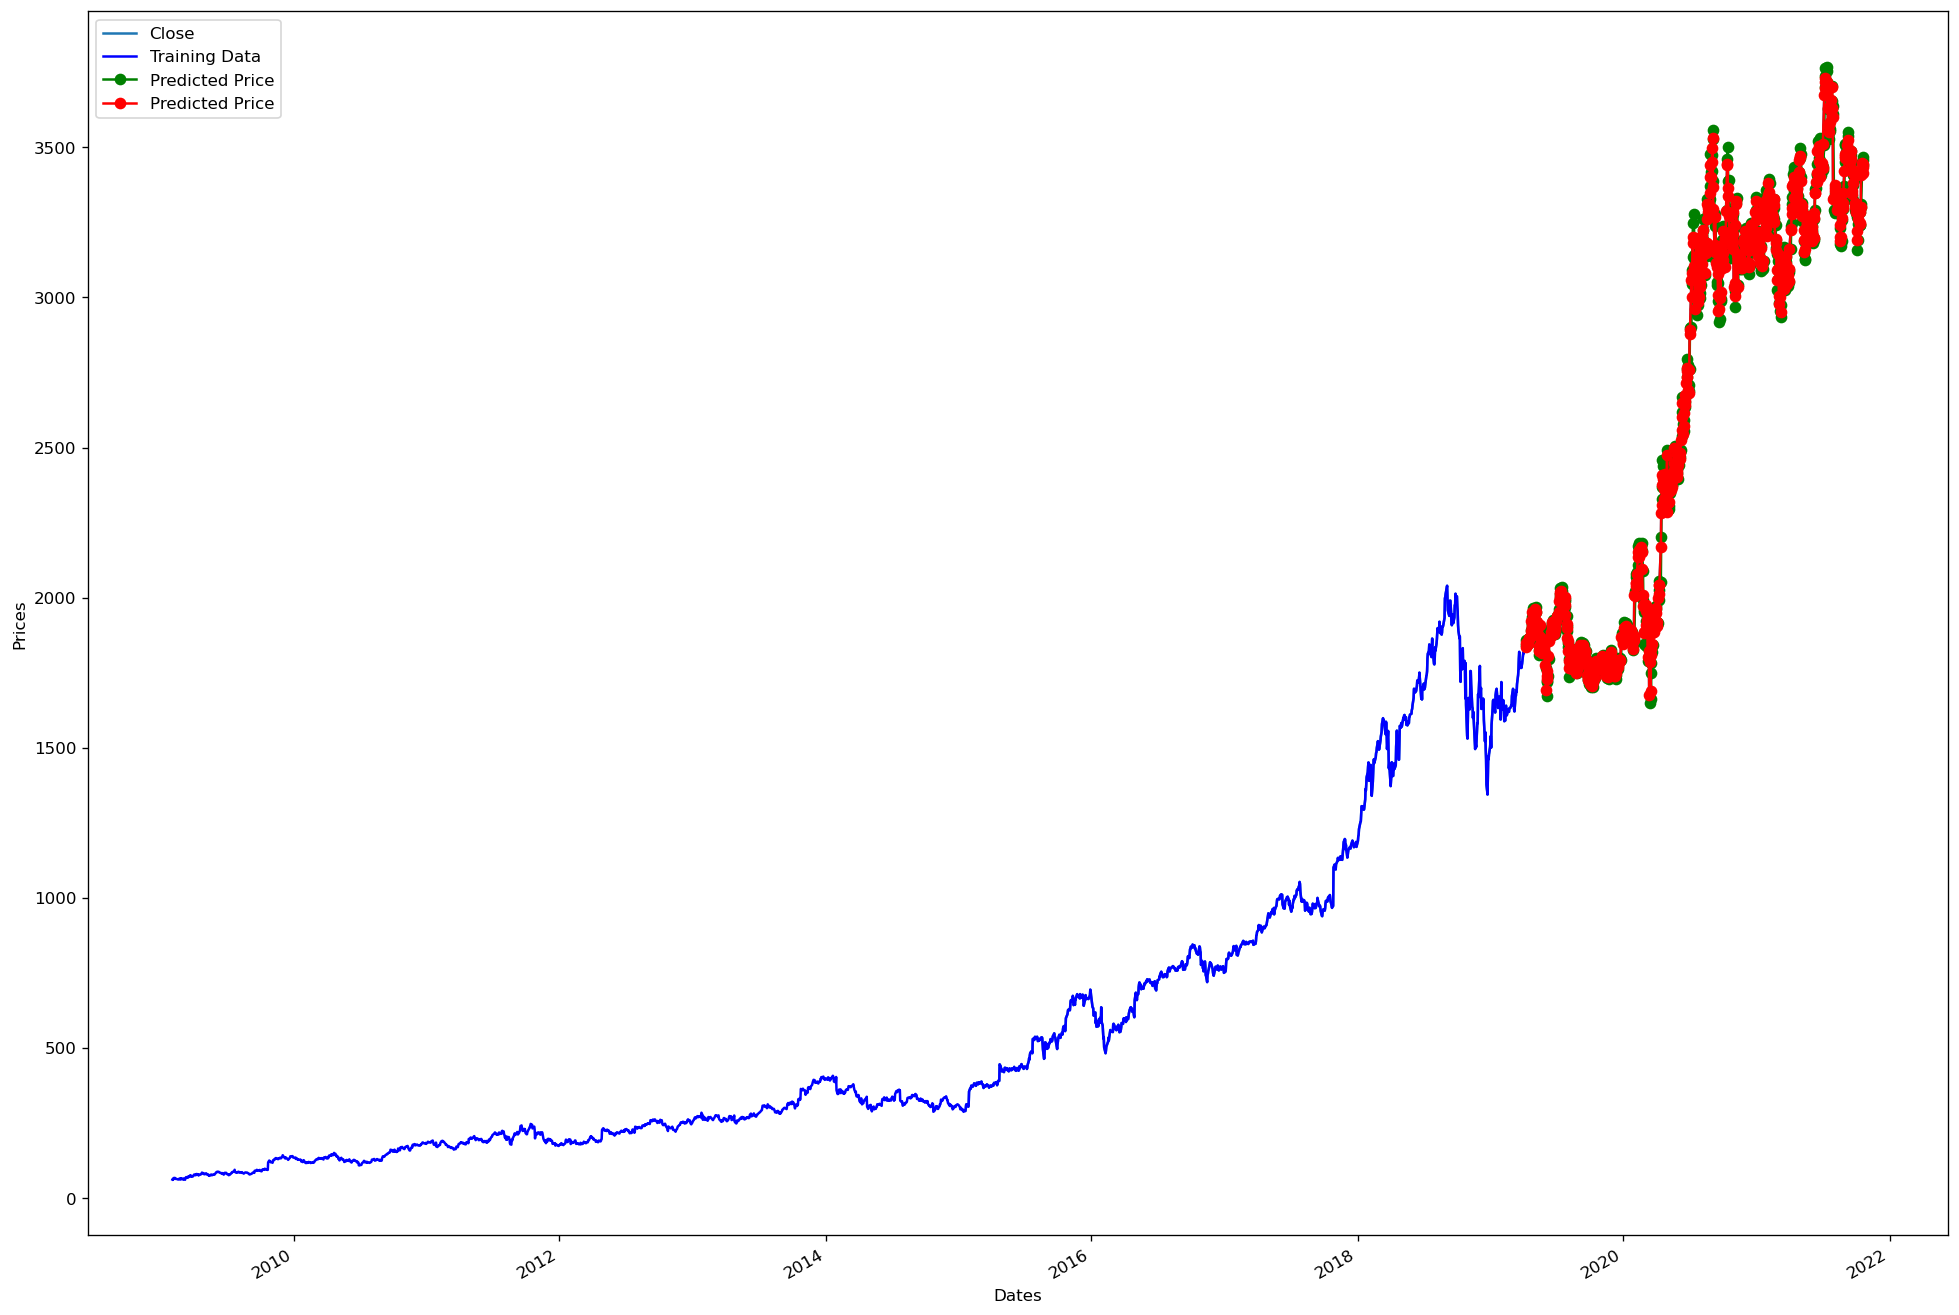

In [26]:
ax = amzn_close.iloc[1500:].plot(label='observed', figsize=(20, 15))
ax.plot(train, color='blue', label='Training Data')
ax.plot(test.index, forecasts, color='green', marker='o',
             label='Predicted Price')
ax.plot(test.index, test, color='red', marker='o', label='Predicted Price')
ax.set_xlabel('Dates')
ax.set_ylabel('Prices')
#axes[0].plot(test_data.index, forecasts, color='green', marker='o',
       #      label='Predicted Price')

plt.legend()
plt.show()

In [27]:
print('The Root Mean Squared Error of prediction is {}'.format(round(np.sqrt(2914.7429774631737), 2)))

The Root Mean Squared Error of prediction is 53.99


## SARIMAX PMDARIMA

In [28]:
smodel = pm.auto_arima(train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=17.01 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=26616.201, Time=0.29 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=21897.136, Time=4.95 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=24481.070, Time=5.92 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=26698.462, Time=0.20 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=22481.663, Time=0.59 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=21525.441, Time=15.19 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=38.70 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=19.68 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=26597.255, Time=9.46 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=21527.365, Time=24.11 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=21527.363, Time=21.15 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=24474.679, Time=17.42 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=21529.413, Time=27.56 sec
 ARIMA(1,0,0)(2

In [29]:
model = smodel  # seeded from the model we've already fit

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in test['Close']:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

print(f"Mean squared error: {mean_squared_error(test['Close'], forecasts)}")
print(f"SMAPE: {smape(test['Close'], forecasts)}")

Mean squared error: 3098.212231889068
SMAPE: 1.5271991054473666


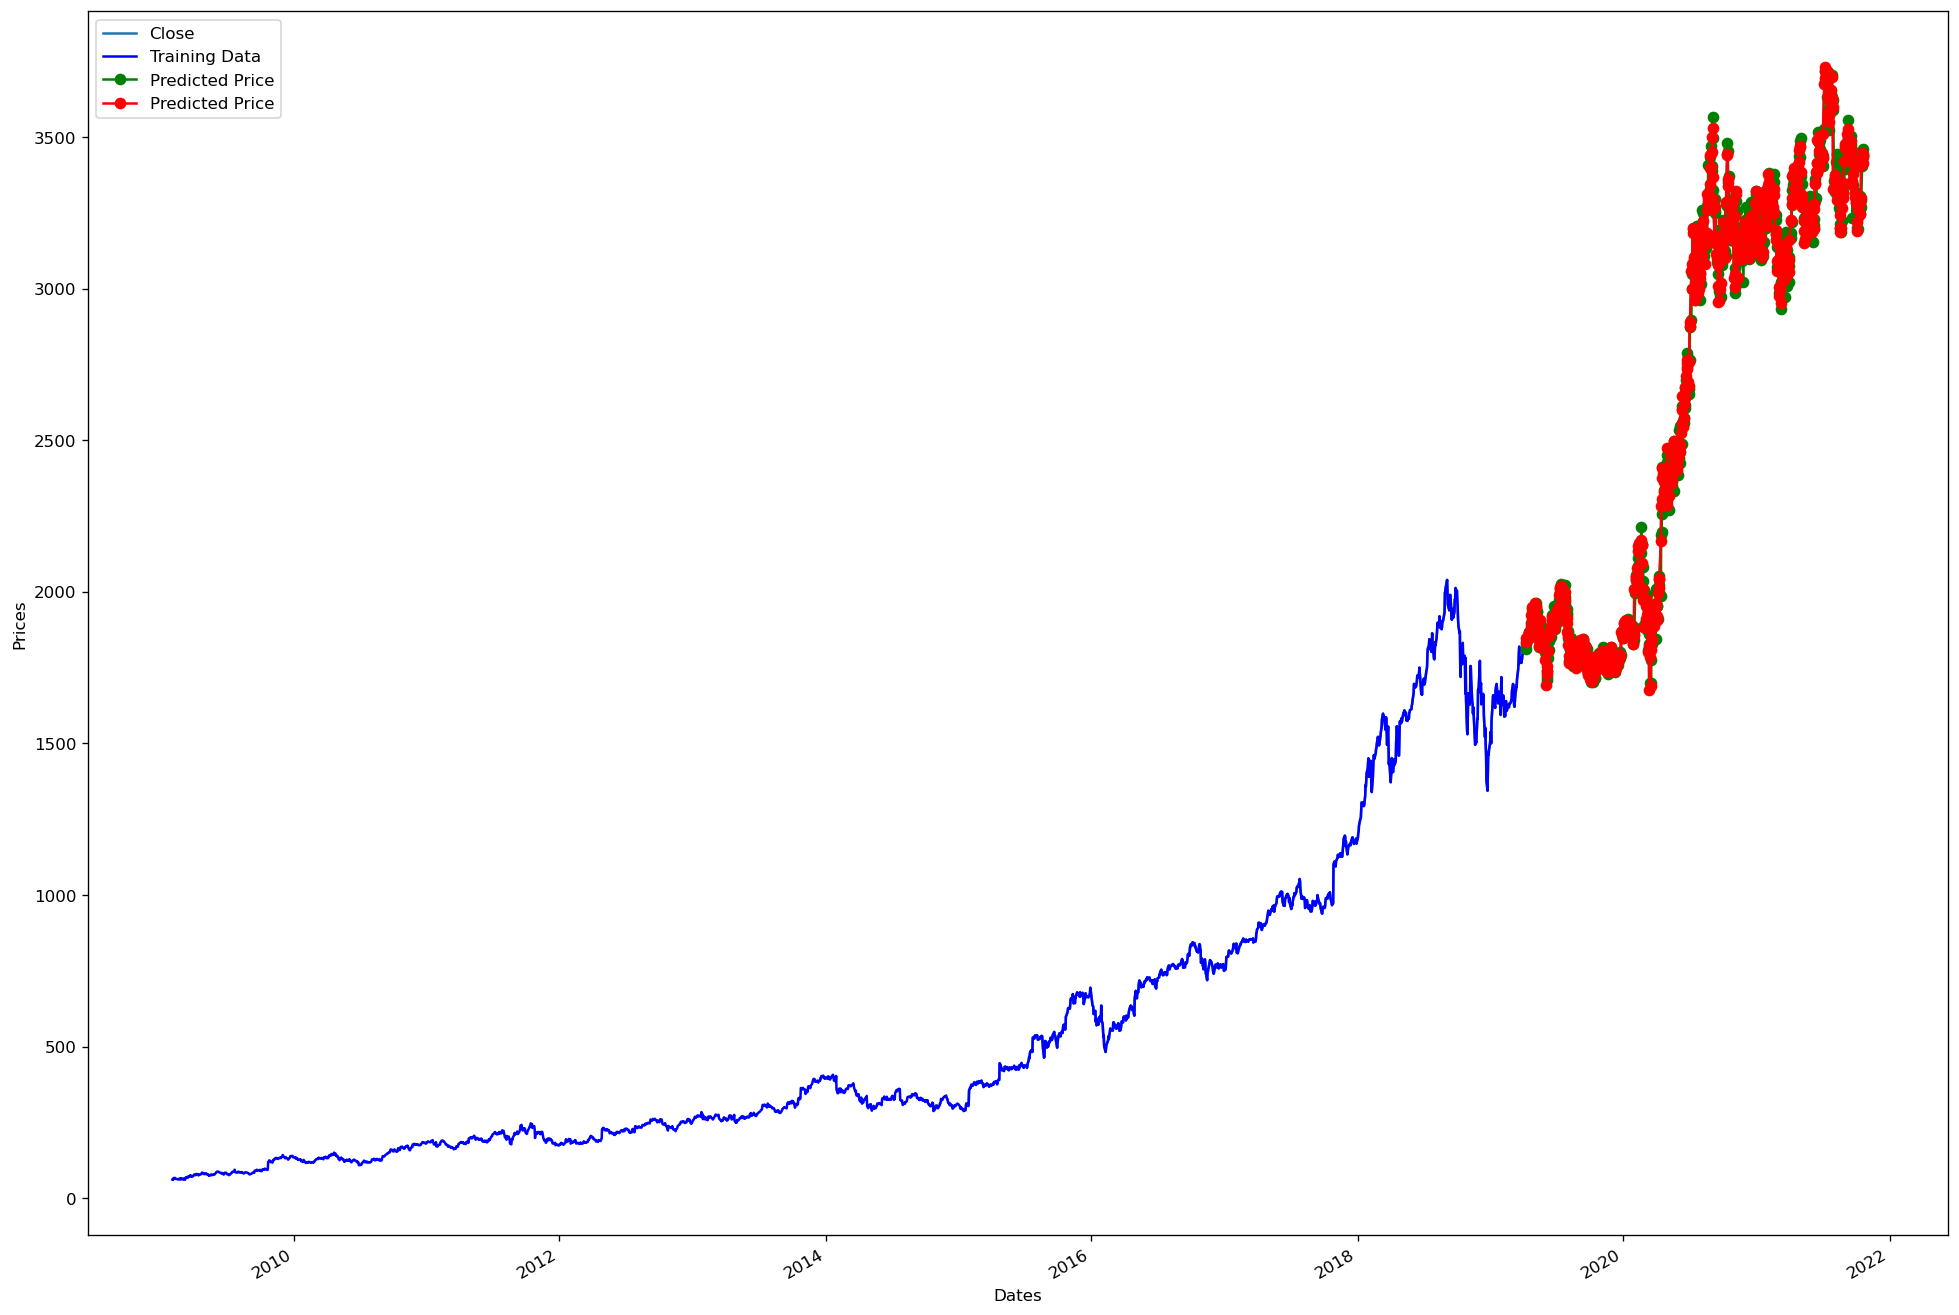

In [30]:
ax = amzn_close.iloc[1500:].plot(label='observed', figsize=(20, 15))
ax.plot(train, color='blue', label='Training Data')
ax.plot(test.index, forecasts, color='green', marker='o',
             label='Predicted Price')
ax.plot(test.index, test, color='red', marker='o', label='Predicted Price')
ax.set_xlabel('Dates')
ax.set_ylabel('Prices')
#axes[0].plot(test_data.index, forecasts, color='green', marker='o',
       #      label='Predicted Price')

plt.legend()
plt.show()

In [32]:
print('The Root Mean Squared Error of prediction is {}'.format(round(np.sqrt(3098.212231889068), 2)))

The Root Mean Squared Error of prediction is 55.66


## FBPROPHET

In [33]:
amzn_close = amzn[['Close']]

In [34]:
amzn = amzn_close.reset_index()

In [35]:
amzn.rename(columns={'Close': 'y', 'Date': 'ds'},inplace=True)
amzn['ds'] = pd.to_datetime(amzn['ds'])
amzn['y']=amzn['y'].astype(float)

In [36]:
df_prophet = Prophet(changepoint_prior_scale=0.15, daily_seasonality=True)
df_prophet.fit(amzn)

In [37]:

fcast_time=365   # 1 year
df_forecast = df_prophet.make_future_dataframe(periods= fcast_time, freq='D')
df_forecast.tail(10)

,ds
3559,2022-10-12
3560,2022-10-13
3561,2022-10-14
3562,2022-10-15
3563,2022-10-16
3564,2022-10-17
3565,2022-10-18
3566,2022-10-19
3567,2022-10-20
3568,2022-10-21


In [38]:
# Forecasting - call the method predict
df_forecast = df_prophet.predict(df_forecast)

In [39]:
df_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3564,2022-10-17,4501.065809,4248.877529,4756.452656
3565,2022-10-18,4506.006400,4259.237511,4752.896786
3566,2022-10-19,4510.178810,4245.451695,4770.914849
3567,2022-10-20,4511.771305,4251.826488,4763.274753
3568,2022-10-21,4511.493914,4274.253639,4757.287077


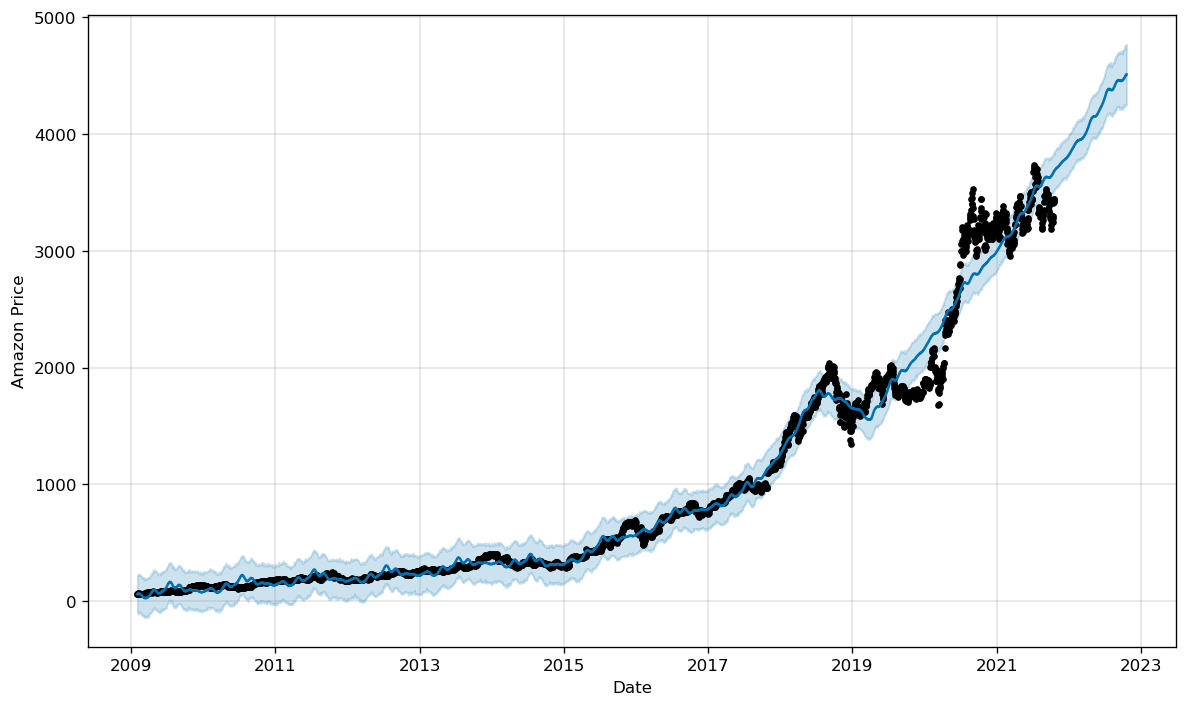

In [40]:
df_prophet.plot(df_forecast, xlabel = 'Date', ylabel = 'Amazon Price');

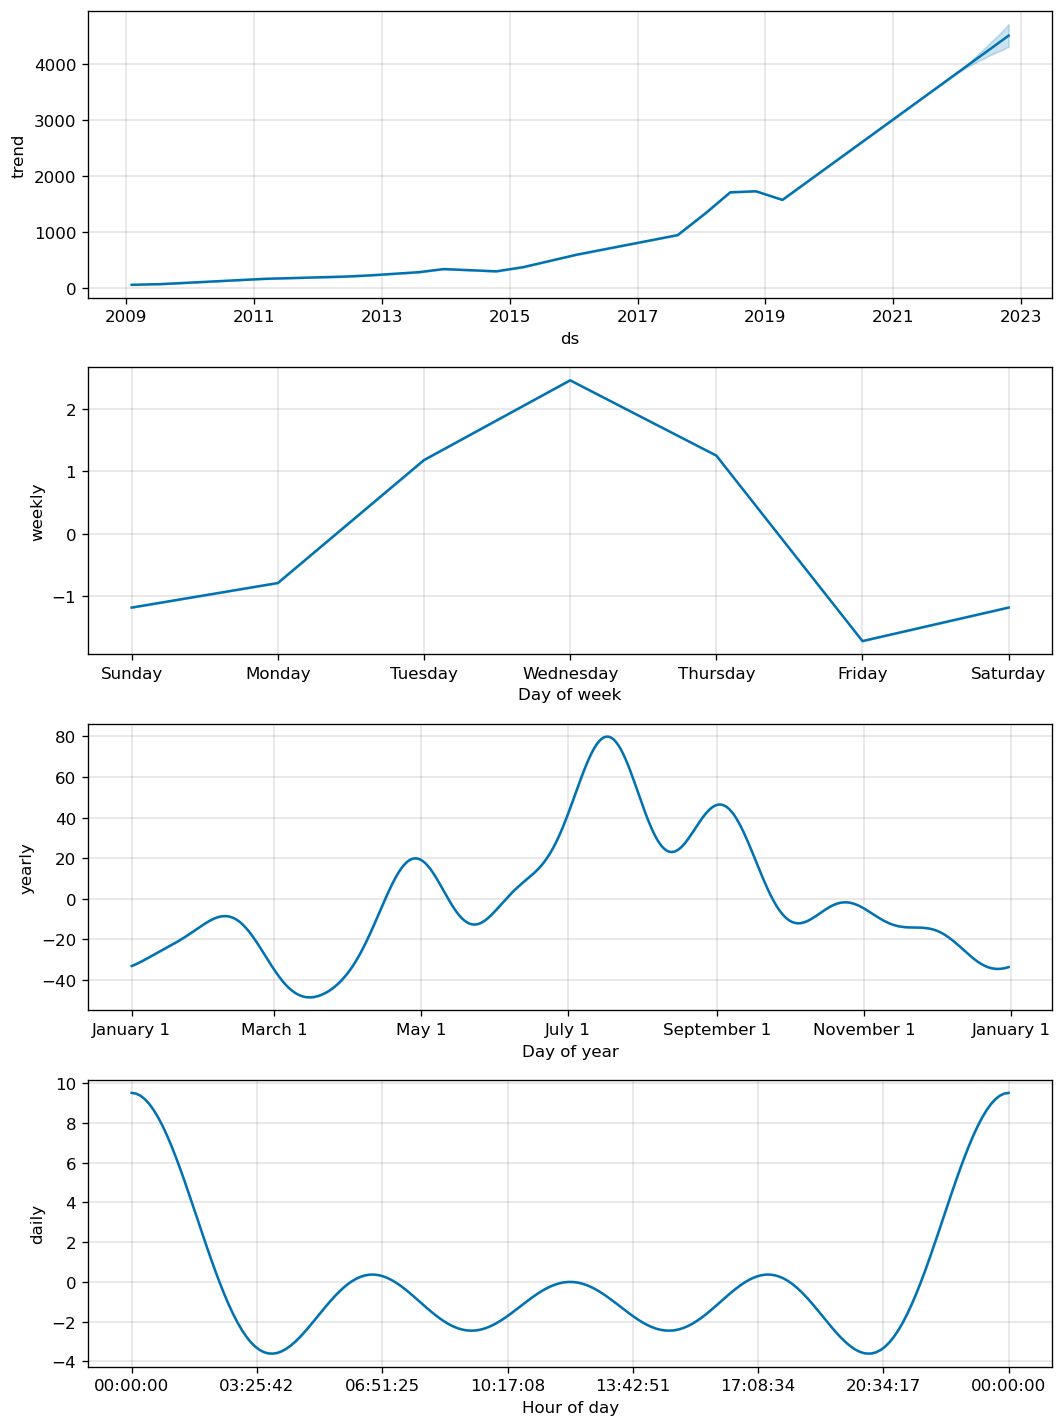

In [41]:

fig2 = df_prophet.plot_components(df_forecast)
plt.show()

In [44]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(df_prophet, horizon = '365 days')

INFO:prophet:Making 18 forecasts with cutoffs between 2012-04-23 12:00:00 and 2020-10-21 00:00:00
100%|██████████| 18/18 [04:27<00:00, 14.84s/it]


In [45]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(df_prophet, horizon = '365 days')

INFO:prophet:Making 18 forecasts with cutoffs between 2012-04-23 12:00:00 and 2020-10-21 00:00:00
100%|██████████| 18/18 [04:57<00:00, 16.54s/it]


## Result

The ARIMA model performed the best with the lowest rmse